<a href="https://colab.research.google.com/github/lizagonch/NLP/blob/master/Copy_of_hashtags_keras_rus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import nltk
import sys
import operator
import pandas as pd
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from collections import defaultdict

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [5]:
!wget https://raw.githubusercontent.com/lizagonch/NLP/master/sem12/data_15k_with_classes_new.csv

--2019-11-27 05:40:16--  https://raw.githubusercontent.com/lizagonch/NLP/master/sem12/data_15k_with_classes_new.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 957086 (935K) [text/plain]
Saving to: ‘data_15k_with_classes_new.csv’

data_15k_with_class 100%[===================>] 934.65K  --.-KB/s    in 0.04s   

2019-11-27 05:40:17 (20.9 MB/s) - ‘data_15k_with_classes_new.csv’ saved [957086/957086]



In [6]:
! wget https://raw.githubusercontent.com/lizagonch/NLP/master/sem12/real_test_data.csv

--2019-11-27 05:40:19--  https://raw.githubusercontent.com/lizagonch/NLP/master/sem12/real_test_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80315 (78K) [text/plain]
Saving to: ‘real_test_data.csv’

real_test_data.csv  100%[===================>]  78.43K  --.-KB/s    in 0.02s   

2019-11-27 05:40:19 (4.88 MB/s) - ‘real_test_data.csv’ saved [80315/80315]



## Train data

In [0]:
import random 
data_train = []
keys = set()
keys.update([''])
n = 10000

cap_letters = ['А', 'Б','В','Г','Д','Е','Ж','З','И','Й','К','Л','М',
               'Н','О','П','Р','С','Т','У','Ф','Х','Ц','Ч','Ш','Щ','Э','Ю','Я']

In [0]:
data = pd.read_csv("data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)

### Building vocabularies

Just like before, we have to build a mapping from tokens to integer ids. This time around, our model operates on a word level, processing one word per RNN step. This means we'll have to deal with far larger vocabulary.

Luckily for us, we only receive those words as input i.e. we don't have to predict them. This means we can have a large vocabulary for free by using word embeddings.

In [0]:
all_chars = set(''.join(data.hashtag.values))
char_to_id = defaultdict(lambda:1,{word:i for i, word in enumerate(all_chars)})
tag_to_id = {tag: i for i, tag in enumerate(['0', '1'])}

In [10]:
len(all_chars)

73

convert words and tags into fixed-size matrix

In [0]:
def to_matrix(lines, token_to_id,
              max_len=None,
              pad=0,
              dtype='int32',
              time_major=False):
    
    """Converts a list of hashtags into rnn-digestable matrix with paddings added after the end"""
    
    max_len = max_len or max(map(len,lines))
    matrix = np.empty([len(lines), max_len], dtype)
    matrix.fill(pad)

    for i in range(len(lines)):
        line_ix = list(map(token_to_id.__getitem__, lines[i]))[:max_len]
        matrix[i,:len(line_ix)] = line_ix

    return matrix.T if time_major else matrix

In [12]:
batch_words, batch_tags = data[:3].hashtag.values, data[:3].true_segmentation.values

print("Word ids:")
print(to_matrix(batch_words, char_to_id))
print("Tag ids:")
print(to_matrix(batch_tags, tag_to_id))

Word ids:
[[24 49 23 30 49 24  5 63 60 60  6  3 69  0  0  0  0  0  0  0  0  0  0  0
   0  0]
 [25  5 44 36 15  6 10 69 60 49  5 49 64 69 13 63 25 10 49  7 72 28 63 60
  30 46]
 [13 63  5 49 45 63 10 72 16 16 72 46 49 25 25 69 69  0  0  0  0  0  0  0
   0  0]]
Tag ids:
[[0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 0 0 0 0 1]
 [0 0 0 0 0 0 1 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]]


In [13]:
df = pd.read_csv("data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
df.head()

hashtag  hashtag_class           true_segmentation
0               подтопленными              5               0000000000001
1  службыкинологической7центр              7  00000100000000000001100001
2           человек7007россии              6           00000010001000001
3                   компанией              5                   000000001
4    поступилосообщениелетней              7    000000001000000001000001

## Test data

2088 – всего хештегов в тестовой выборке 

из которых:
* 239 хештегов с аббревиатурами
* 449 однословные с заглавной буквы
* 269 двусловные разделённые заглавной буквой (в большинстве случаев начинаются тоже с заглавной)
* 53 трехсловные разделённые заглавными буквами (в большинстве случаев начинаются тоже с заглавной)
* 6 четыре слова разделённые заглавными буквами
* 1072 1+ слов без заглавных букв в строке 

In [0]:
real_test_data = pd.read_csv("real_test_data.csv")

In [15]:
real_test_data.columns

Index(['Unnamed: 0', 'hashtag', 'true_segmentation', 'flag'], dtype='object')

In [16]:
real_test_data.drop(['Unnamed: 0'], inplace=True, axis=1)
real_test_data.head()

hashtag true_segmentation   flag
0  ЁлкаВЗазеркалье   000110000000001  False
1          АКЕРБАТ           0000001  False
2             АКИТ              0001  False
3             АРМИ              0001  False
4          Абхазия           0000001  False

In [17]:
real_test_data.shape

(1950, 3)

## Building model

By default, all keras RNNs apply to a whole sequence of inputs and produce a sequence of hidden states `(return_sequences=True` or just the last hidden state `(return_sequences=False)`. All the recurrence is happening under the hood.

At the top of our model we need to apply a Dense layer to each time-step independently. As of now, by default keras.layers.Dense would apply once to all time-steps concatenated. We use __keras.layers.TimeDistributed__ to modify Dense layer so that it would apply across both batch and time axes.

In [18]:
import keras
import keras.layers as L

model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_chars), 50)) # dim 100
model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))

#add top layer that predicts tag probabilities
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

Using TensorFlow backend.


__Training:__ in this case we don't want to prepare the whole training dataset in advance. The main cause is that the length of every batch depends on the maximum sentence length within the batch. This leaves us two options: use custom training code or use generators.

Keras models have a __`model.fit_generator`__ method that accepts a python generator yielding one batch at a time. But first we need to implement such generator:

In [0]:
from keras.utils.np_utils import to_categorical

BATCH_SIZE=32
def generate_batches(sentences, batch_size=BATCH_SIZE, max_len=None, pad=0):
    
    assert isinstance(sentences,pd.DataFrame), "Make sure sentences is q pd dataframe"
    
    
    while True:
        indices = np.random.permutation(np.arange(len(sentences)))
        for start in range(0,len(indices)-1,batch_size):
            batch_indices = indices[start:start+batch_size]
            batch_sentences = sentences.iloc[batch_indices]
            batch_chars = batch_sentences.hashtag.values
            batch_tags = batch_sentences.true_segmentation.values
            batch_chars = to_matrix(batch_chars, char_to_id, max_len, pad)
            batch_tags = to_matrix(batch_tags, tag_to_id, max_len, pad)

            batch_tags_1hot = to_categorical(batch_tags, 2).reshape(batch_tags.shape+(-1,))
            yield batch_chars,batch_tags_1hot
        

__Callbacks:__ Another thing we need is to measure model performance. The tricky part is not to count accuracy after sentence ends (on padding) and making sure we count all the validation data exactly once.

While it isn't impossible to persuade Keras to do all of that, we may as well write our own callback that does that.
Keras callbacks allow you to write a custom code to be ran once every epoch or every minibatch. We'll define one via LambdaCallback

In [0]:
def compute_test_accuracy(model):
    #TRAIN_ACC
    test_words = test_data.hashtag.values
    test_tags = test_data.true_segmentation.values
    test_words,test_tags = to_matrix(test_words, char_to_id),to_matrix(test_tags,tag_to_id)
    
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    
    train_acc = float(numerator)/denominator
    
    #TEST_ACC
    real_test_words = real_test_data.hashtag.values
    real_test_tags = real_test_data.true_segmentation.values
    real_test_words,real_test_tags = to_matrix(real_test_words, char_to_id),to_matrix(real_test_tags,tag_to_id)
    
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities_ = model.predict(real_test_words,verbose=1)
    predicted_tags_ = predicted_tag_probabilities_.argmax(axis=-1)

    #compute accurary excluding padding
    numerator_ = np.sum(np.logical_and((predicted_tags_ == real_test_tags),(real_test_words != 0)))
    denominator_ = np.sum(real_test_words != 0)
    
    test_acc = float(numerator_)/denominator_
    
    return train_acc, test_acc

train_accs = []
test_accs = []

class EvaluateAccuracy(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        train_acc, test_acc = compute_test_accuracy(self.model)
        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print("\nValidation accuracy: %.5f\n"%train_acc)
        print("\nReal test_data accuracy: %.5f\n"%test_acc)
        sys.stdout.flush()
        

# training 1
15k  
5 epochs   

In [0]:
model = keras.models.Sequential()
model.add(L.InputLayer([None], dtype='int32'))
model.add(L.Embedding(len(all_chars), 50)) # dim 100
model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model.add(stepwise_dense)

In [22]:
model.compile('adam', 'categorical_crossentropy')

In [23]:
data = pd.read_csv("./data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
train_data, test_data = train_test_split(data, test_size=0.25, random_state=42)
data.shape

(15000, 3)

In [24]:
history = model.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=5,)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/5





352/351 [==============================] - 26s 73ms/step - loss: 0.1496

Measuring validation accuracy...
1950/1950 [==============================] - 1s 303us/step

Validation accuracy: 0.96486


Real test_data accuracy: 0.96694

Epoch 2/5
352/351 [==============================] - 23s 65ms/step - loss: 0.0413

Measuring validation accuracy...
1950/1950 [==============================] - 1s 272us/step

Validation accuracy: 0.97378


Real test_data accuracy: 0.97629

Epoch 3/5
352/351 [==============================] - 24s 68ms/step - loss: 0.0300

Measuring validation accuracy...
1950/1950 [==============================] - 1s 310us/step

Validation accuracy: 0.98312


Real test_data accuracy: 0.97980

Epoch 4/5
352/351 [==============================] - 24s 69ms/step - loss: 0.0226

Measuring validation accuracy...
1950/1950 [==============================] - 1s 313us/step


Measure final accuracy on the whole test set.

In [25]:
train_acc, test_acc = compute_test_accuracy(model)
print("Final train accuracy: %.5f"%train_acc)
print("Final test accuracy: %.5f"%test_acc)

1950/1950 [==============================] - 1s 260us/step
Final train accuracy: 0.98566
Final test accuracy: 0.98161


# Active Learning

In [0]:
def compute_test_accuracy_al(model):
    #TRAIN_ACC
    test_words = test_data.hashtag.values
    test_tags = test_data.true_segmentation.values
    test_words,test_tags = to_matrix(test_words, char_to_id),to_matrix(test_tags,tag_to_id)
    
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model.predict(test_words,verbose=1)
    predicted_tags = predicted_tag_probabilities.argmax(axis=-1)

    #compute accurary excluding padding
    numerator = np.sum(np.logical_and((predicted_tags == test_tags),(test_words != 0)))
    denominator = np.sum(test_words != 0)
    
    train_acc = float(numerator)/denominator
    return train_acc

train_accs_al = []
test_accs_al = []

class EvaluateAccuracy_al(keras.callbacks.Callback):
    def on_epoch_end(self,epoch,logs=None):
        sys.stdout.flush()
        print("\nMeasuring validation accuracy...")
        train_acc = compute_test_accuracy_al(self.model)
        train_accs_al.append(train_acc)
        print("\nValidation accuracy: %.5f\n"%train_acc)
        sys.stdout.flush()
        

In [0]:
def checker(words, predicted_tag_probabilities):
    "gets probability of segmentation"
    res = []
    for w, predicted_tag_prob in tqdm(zip(words, predicted_tag_probabilities)):
        prob = np.prod(predicted_tag_prob.max(axis=-1))/len(predicted_tag_prob)
        res.append((w, prob))
    return res

In [28]:
df_15k = pd.read_csv("data_15k_with_classes_new.csv", index_col=None).iloc[:, 1:]
df_15k.shape

(15000, 3)

In [0]:
history_loss_al = []

In [0]:
df_15k_shuffled = df_15k.reindex(np.random.permutation(df_15k.index))
start_1k = df_15k.iloc[:1000]

In [36]:
df_15k_shuffled.head()

hashtag  ...                  true_segmentation
5602                    ЯЙЮФЩнаходящийся  ...                   0000100000000001
10658             СуворовскийНатиск_4110  ...             0000000000100000110001
9995   ВсеармейскогоЭтапаКонкурса_полном  ...  000000000000100001000000011000001
14269                 военно_медицинской  ...                 000001100000000001
2127                            концерты  ...                           00000001

[5 rows x 3 columns]

In [0]:
model_al = keras.models.Sequential()
model_al.add(L.InputLayer([None], dtype='int32'))
model_al.add(L.Embedding(len(all_chars), 50)) # dim 100
model_al.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model_al.add(stepwise_dense)

In [0]:
model_al.compile('adam', 'categorical_crossentropy')

In [0]:
train_data = start_1k
test_data = df_15k.iloc[1000:]#df_15k_shuffled.iloc[1000:]

In [47]:
for i in range(4):
    history = model_al.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE, 
                                     callbacks=[EvaluateAccuracy_al()], epochs=5,)
    history_loss_al += history.history['loss']
    
    test_words_al_text = test_data.hashtag.values
    test_tags_al = test_data.true_segmentation.values
    test_words_al, test_tags_al = to_matrix(test_words_al_text, char_to_id), to_matrix(test_tags_al, tag_to_id)
    
    #predict tag probabilities of shape [batch,time,n_tags]
    predicted_tag_probabilities = model_al.predict(test_words_al,verbose=1)
    probs = checker(test_words_al_text, predicted_tag_probabilities)
    print(probs)
    probs_sorted = sorted(probs, key=operator.itemgetter(1), reverse=False)
    add_1k = [i[0] for i in probs_sorted[:1000]]
    mrg_1k = df_15k_shuffled.loc[df_15k_shuffled['hashtag'].isin(add_1k)]
    
    train_data = pd.concat([train_data, mrg_1k])
    test_data = df_15k_shuffled.loc[~df_15k_shuffled['hashtag'].isin(train_data.hashtag.tolist())]
    print(i)
    

Epoch 1/5
63/62 [==============================] - 5s 76ms/step - loss: 0.0490

Measuring validation accuracy...
13000/13000 [==============================] - 6s 474us/step

Validation accuracy: 0.97241

Epoch 2/5
63/62 [==============================] - 5s 78ms/step - loss: 0.0405

Measuring validation accuracy...
13000/13000 [==============================] - 7s 532us/step

Validation accuracy: 0.97371

Epoch 3/5
63/62 [==============================] - 5s 76ms/step - loss: 0.0383

Measuring validation accuracy...
13000/13000 [==============================] - 7s 525us/step

Validation accuracy: 0.97421

Epoch 4/5
63/62 [==============================] - 5s 76ms/step - loss: 0.0368

Measuring validation accuracy...
13000/13000 [==============================] - 7s 503us/step

Validation accuracy: 0.97505

Epoch 5/5
63/62 [==============================] - 5s 73ms/step - loss: 0.0361

Measuring validation accuracy...
13000/13000 [==============================] - 7s 508us/step

Valid

13000it [00:00, 74094.74it/s]


[('ЯЙЮФЩнаходящийся', 0.004369707571135627), ('СуворовскийНатиск_4110', 0.014216030085528339), ('ВсеармейскогоЭтапаКонкурса_полном', 0.011115616118466412), ('военно_медицинской', 0.016568496271415992), ('концерты', 0.0174580834530018), ('КЭЙК', 0.007826081028691045), ('772стилем', 0.01751038432121277), ('технического4534безопасностирегламента', 0.00621461757907161), ('фотоалександр_4', 0.009297000037299262), ('предлагает_проводить_говорит', 0.015219692830686216), ('банка403почта', 0.01748535368177626), ('успешноговыполнения', 0.005379506283336216), ('рублейтираж_76', 0.006253334659117239), ('поручению_президента', 0.01721204651726617), ('Полугодия', 0.018331540955437556), ('РекордовГиннесса', 0.01694584886233012), ('Приеме_288', 0.016494407697960182), ('хоккею_среди_полицейских', 0.01672251025835673), ('мвдроссииНародный_республик', 0.014776666959126791), ('ДПДЮ_82', 0.014908939599990845), ('310Автомобильный', 0.016050994396209717), ('деятельностиоргановвнутренних_Войти', 0.00492315104

12000it [00:00, 74556.35it/s]

[('СуворовскийНатиск_4110', 0.017014100595756813), ('ВсеармейскогоЭтапаКонкурса_полном', 0.014123146180753355), ('военно_медицинской', 0.017892472170017385), ('концерты', 0.018070146993354515), ('КЭЙК', 0.01467972993850708), ('772стилем', 0.018063263760672674), ('технического4534безопасностирегламента', 0.008378426233927408), ('фотоалександр_4', 0.013146719446888677), ('предлагает_проводить_говорит', 0.009979831951635855), ('банка403почта', 0.01811025650412948), ('рублейтираж_76', 0.007466286972717002), ('поручению_президента', 0.01799088054233127), ('Полугодия', 0.01801178300822223), ('РекордовГиннесса', 0.017350078732879075), ('Приеме_288', 0.01784734151981495), ('хоккею_среди_полицейских', 0.01791408658027649), ('мвдроссииНародный_республик', 0.015054665229938648), ('ДПДЮ_82', 0.008318566061832287), ('310Автомобильный', 0.015882694058948092), ('Артиллерии8285РублейДанномуТысяч', 0.017321093214882746), ('большое_количество', 0.018193586005104914), ('НезаконномХранении', 0.01825044552

1
Epoch 1/5
125/125 [==============================] - 10s 78ms/step - loss: 0.0374

Measuring validation accuracy...
11000/11000 [==============================] - 6s 535us/step

Validation accuracy: 0.99347

Epoch 2/5
125/125 [==============================] - 9s 73ms/step - loss: 0.0348

Measuring validation accuracy...
11000/11000 [==============================] - 5s 500us/step

Validation accuracy: 0.99350

Epoch 3/5
125/125 [==============================] - 9s 75ms/step - loss: 0.0323

Measuring validation accuracy...
11000/11000 [==============================] - 6s 500us/step

Validation accuracy: 0.99383

Epoch 4/5
125/125 [==============================] - 9s 75ms/step - loss: 0.0306

Measuring validation accuracy...
11000/11000 [==============================] - 6s 560us/step

Validation accuracy: 0.99366

Epoch 5/5
125/125 [==============================] - 10s 79ms/step - loss: 0.0291

Measuring validation accuracy...
11000/11000 [==============================] - 6s 547

11000it [00:00, 53295.58it/s]


[('СуворовскийНатиск_4110', 0.017194828501454106), ('ВсеармейскогоЭтапаКонкурса_полном', 0.014511106190858063), ('военно_медицинской', 0.018256847505216247), ('концерты', 0.01835120607305456), ('КЭЙК', 0.016483067362396804), ('772стилем', 0.018327894034209074), ('фотоалександр_4', 0.008804517763632315), ('предлагает_проводить_говорит', 0.010244456706223664), ('банка403почта', 0.01835930347442627), ('поручению_президента', 0.01836815697175485), ('Полугодия', 0.01822356383005778), ('РекордовГиннесса', 0.017183200076774315), ('Приеме_288', 0.018316150815398606), ('хоккею_среди_полицейских', 0.01827013051068341), ('мвдроссииНародный_республик', 0.011541486890227706), ('310Автомобильный', 0.017335687522534973), ('Артиллерии8285РублейДанномуТысяч', 0.0179955021098808), ('большое_количество', 0.018406981671297992), ('НезаконномХранении', 0.017871012290318806), ('Экземпляров_Вышла', 0.010045602365776344), ('ПЭЩ_338', 0.01774059732755025), ('5477Идлиб', 0.017515406564429955), ('дан46старт', 0.0

10000it [00:00, 58492.82it/s]


[('СуворовскийНатиск_4110', 0.018264336718453303), ('ВсеармейскогоЭтапаКонкурса_полном', 0.01749731876232006), ('военно_медицинской', 0.018178611993789673), ('концерты', 0.01840390651314347), ('КЭЙК', 0.015039746408109312), ('772стилем', 0.018378091079217417), ('банка403почта', 0.018431219789716933), ('поручению_президента', 0.018455541796154447), ('Полугодия', 0.018386956718232896), ('РекордовГиннесса', 0.01669764518737793), ('Приеме_288', 0.018368181255128648), ('хоккею_среди_полицейских', 0.01837703475245723), ('310Автомобильный', 0.018186893728044298), ('Артиллерии8285РублейДанномуТысяч', 0.01755141880777147), ('большое_количество', 0.01784851484828525), ('НезаконномХранении', 0.017953819698757596), ('ПЭЩ_338', 0.018252902560763888), ('5477Идлиб', 0.017717964119381376), ('дан46старт', 0.018212416657695064), ('средствМвд_колледжей', 0.018269075287712946), ('министрСвязи_4669', 0.01836506415296484), ('проведениюспасательныхОпераций_Ночного', 0.018307667087625573), ('Почтамаркет', 0.0

9000it [00:00, 74755.15it/s]

[('СуворовскийНатиск_4110', 0.01841413864382991), ('ВсеармейскогоЭтапаКонкурса_полном', 0.01823365909081918), ('военно_медицинской', 0.018403863465344464), ('концерты', 0.018429075126294738), ('772стилем', 0.01840681058389169), ('банка403почта', 0.018432460449360036), ('поручению_президента', 0.01850054661432902), ('Полугодия', 0.018457804565076476), ('РекордовГиннесса', 0.017853403532946552), ('Приеме_288', 0.018364176706031517), ('хоккею_среди_полицейских', 0.01835535411481504), ('310Автомобильный', 0.018393886310082895), ('Артиллерии8285РублейДанномуТысяч', 0.018158017485230056), ('большое_количество', 0.018000575127425016), ('НезаконномХранении', 0.01841834408265573), ('ПЭЩ_338', 0.018355539551487676), ('5477Идлиб', 0.018038639315852412), ('дан46старт', 0.018449529453560157), ('средствМвд_колледжей', 0.01825120934733638), ('министрСвязи_4669', 0.018444023750446462), ('проведениюспасательныхОпераций_Ночного', 0.018439965115653142), ('Почтамаркет', 0.017937160200542875), ('Учитывая_С

219/218 [==============================] - 16s 71ms/step - loss: 0.0126

Measuring validation accuracy...
8000/8000 [==============================] - 4s 486us/step

Validation accuracy: 0.99965

Epoch 2/5
219/218 [==============================] - 16s 73ms/step - loss: 0.0119

Measuring validation accuracy...
8000/8000 [==============================] - 4s 477us/step

Validation accuracy: 0.99964

Epoch 3/5
219/218 [==============================] - 16s 73ms/step - loss: 0.0107

Measuring validation accuracy...
8000/8000 [==============================] - 4s 467us/step

Validation accuracy: 0.99963

Epoch 4/5
219/218 [==============================] - 16s 73ms/step - loss: 0.0097

Measuring validation accuracy...
8000/8000 [==============================] - 4s 487us/step

Validation accuracy: 0.99964

Epoch 5/5
219/218 [==============================] - 16s 72ms/step - loss: 0.0089

Measuring validation accuracy...
8000/8000 [==============================] - 4s 483us/step

Validation

8000it [00:00, 73744.22it/s]

[('СуворовскийНатиск_4110', 0.01993968367576599), ('ВсеармейскогоЭтапаКонкурса_полном', 0.0199417781829834), ('военно_медицинской', 0.019987494945526124), ('концерты', 0.019963914155960084), ('772стилем', 0.019939929246902466), ('банка403почта', 0.01994651198387146), ('поручению_президента', 0.019995579719543456), ('Полугодия', 0.019992730617523193), ('РекордовГиннесса', 0.01991303324699402), ('Приеме_288', 0.019935147762298586), ('хоккею_среди_полицейских', 0.019968812465667726), ('310Автомобильный', 0.0198894202709198), ('Артиллерии8285РублейДанномуТысяч', 0.019792332649230956), ('большое_количество', 0.01987234950065613), ('НезаконномХранении', 0.01987328886985779), ('ПЭЩ_338', 0.019901262521743776), ('5477Идлиб', 0.019697734117507935), ('дан46старт', 0.019971165657043457), ('средствМвд_колледжей', 0.019634965658187866), ('министрСвязи_4669', 0.019969387054443358), ('проведениюспасательныхОпераций_Ночного', 0.01998364329338074), ('Почтамаркет', 0.01972764849662781), ('Учитывая_Склад

250/250 [==============================] - 18s 72ms/step - loss: 0.0078

Measuring validation accuracy...
7000/7000 [==============================] - 3s 444us/step

Validation accuracy: 0.99988

Epoch 2/5
250/250 [==============================] - 18s 71ms/step - loss: 0.0072

Measuring validation accuracy...
7000/7000 [==============================] - 3s 431us/step

Validation accuracy: 0.99988

Epoch 3/5
250/250 [==============================] - 18s 73ms/step - loss: 0.0064

Measuring validation accuracy...
7000/7000 [==============================] - 3s 459us/step

Validation accuracy: 0.99988

Epoch 4/5
250/250 [==============================] - 18s 73ms/step - loss: 0.0058

Measuring validation accuracy...
7000/7000 [==============================] - 3s 443us/step

Validation accuracy: 0.99988

Epoch 5/5
250/250 [==============================] - 18s 70ms/step - loss: 0.0054

Measuring validation accuracy...
7000/7000 [==============================] - 3s 477us/step

Validation

7000it [00:00, 64946.70it/s]

[('СуворовскийНатиск_4110', 0.02125255985462919), ('ВсеармейскогоЭтапаКонкурса_полном', 0.021256406256493103), ('военно_медицинской', 0.021270902867012834), ('концерты', 0.021270810289585843), ('772стилем', 0.021236401923159336), ('банка403почта', 0.021251734266889855), ('поручению_президента', 0.021275254006081438), ('Полугодия', 0.02127425214077564), ('РекордовГиннесса', 0.021258247659561483), ('Приеме_288', 0.02125037096916361), ('хоккею_среди_полицейских', 0.021245262724287967), ('310Автомобильный', 0.021216731122199524), ('Артиллерии8285РублейДанномуТысяч', 0.02120948852376735), ('большое_количество', 0.021241658545554952), ('НезаконномХранении', 0.021187674491963487), ('ПЭЩ_338', 0.02119813193666174), ('дан46старт', 0.021269070341231974), ('министрСвязи_4669', 0.021261134046189328), ('проведениюспасательныхОпераций_Ночного', 0.021267112265241906), ('Учитывая_Складывающиеся_Погодные', 0.021268421031059102), ('преодоление_полосы_препятствий', 0.02126733292924597), ('230основного', 

282/281 [==============================] - 21s 74ms/step - loss: 0.0044

Measuring validation accuracy...
6000/6000 [==============================] - 3s 427us/step

Validation accuracy: 0.99992

Epoch 2/5
282/281 [==============================] - 20s 71ms/step - loss: 0.0041

Measuring validation accuracy...
6000/6000 [==============================] - 3s 464us/step

Validation accuracy: 0.99992

Epoch 3/5
282/281 [==============================] - 20s 70ms/step - loss: 0.0038

Measuring validation accuracy...
6000/6000 [==============================] - 3s 459us/step

Validation accuracy: 0.99992

Epoch 4/5
282/281 [==============================] - 20s 70ms/step - loss: 0.0032

Measuring validation accuracy...
6000/6000 [==============================] - 2s 414us/step

Validation accuracy: 0.99992

Epoch 5/5
282/281 [==============================] - 20s 69ms/step - loss: 0.0028

Measuring validation accuracy...
6000/6000 [==============================] - 2s 414us/step

Validation

6000it [00:00, 63146.15it/s]

[('СуворовскийНатиск_4110', 0.021266097718096795), ('ВсеармейскогоЭтапаКонкурса_полном', 0.02125931166587992), ('военно_медицинской', 0.021275284442495792), ('концерты', 0.02127543662456756), ('772стилем', 0.02124756447812344), ('банка403почта', 0.021263546132026835), ('поручению_президента', 0.021275888098047136), ('Полугодия', 0.021273653557960022), ('РекордовГиннесса', 0.02127247414690383), ('Приеме_288', 0.021260190517344374), ('хоккею_среди_полицейских', 0.02127486340543057), ('310Автомобильный', 0.021234313224224335), ('Артиллерии8285РублейДанномуТысяч', 0.021248715989133145), ('большое_количество', 0.021266776196500088), ('дан46старт', 0.02127238283766077), ('министрСвязи_4669', 0.02127015844304511), ('проведениюспасательныхОпераций_Ночного', 0.0212709700807612), ('Учитывая_Складывающиеся_Погодные', 0.021273876758331946), ('преодоление_полосы_препятствий', 0.0212751068967454), ('230основного', 0.021247584769066345), ('СодействияСемейному8', 0.021275857661632782), ('телесныеповре

313/312 [==============================] - 22s 69ms/step - loss: 0.0024

Measuring validation accuracy...
5000/5000 [==============================] - 2s 461us/step

Validation accuracy: 0.99994

Epoch 2/5
313/312 [==============================] - 22s 71ms/step - loss: 0.0021

Measuring validation accuracy...
5000/5000 [==============================] - 2s 463us/step

Validation accuracy: 0.99994

Epoch 3/5
313/312 [==============================] - 22s 70ms/step - loss: 0.0019

Measuring validation accuracy...
5000/5000 [==============================] - 2s 458us/step

Validation accuracy: 0.99994

Epoch 4/5
313/312 [==============================] - 23s 72ms/step - loss: 0.0022

Measuring validation accuracy...
5000/5000 [==============================] - 2s 445us/step

Validation accuracy: 0.99994

Epoch 5/5
313/312 [==============================] - 22s 70ms/step - loss: 0.0016

Measuring validation accuracy...
5000/5000 [==============================] - 2s 438us/step

Validation

5000it [00:00, 77197.39it/s]

[('СуворовскийНатиск_4110', 0.021270278920518592), ('ВсеармейскогоЭтапаКонкурса_полном', 0.021265809840344367), ('военно_медицинской', 0.021275378288106717), ('концерты', 0.02127630152600877), ('банка403почта', 0.021272417078626916), ('поручению_президента', 0.021276461317184123), ('Полугодия', 0.02127622289860502), ('РекордовГиннесса', 0.021275725770503916), ('Приеме_288', 0.02126943938275601), ('хоккею_среди_полицейских', 0.021274239458936327), ('большое_количество', 0.021271224985731408), ('дан46старт', 0.02127563699762872), ('министрСвязи_4669', 0.021273118384340976), ('проведениюспасательныхОпераций_Ночного', 0.021269136286796407), ('Учитывая_Складывающиеся_Погодные', 0.02127467825057659), ('преодоление_полосы_препятствий', 0.021276372544308926), ('СодействияСемейному8', 0.02127624826228365), ('сотрудникипатрульно_матчей', 0.0211716040651849), ('Течение_Трех_Дней', 0.02127632181695167), ('44Узлы', 0.021273235057262665), ('Туда_030', 0.021271415213321116), ('жизненный_совета', 0.02

344/343 [==============================] - 24s 71ms/step - loss: 0.0011

Measuring validation accuracy...
4000/4000 [==============================] - 2s 422us/step

Validation accuracy: 0.99995

Epoch 2/5
344/343 [==============================] - 24s 71ms/step - loss: 0.0015

Measuring validation accuracy...
4000/4000 [==============================] - 2s 440us/step

Validation accuracy: 0.99995

Epoch 3/5
344/343 [==============================] - 24s 71ms/step - loss: 0.0014

Measuring validation accuracy...
4000/4000 [==============================] - 2s 449us/step

Validation accuracy: 0.99995

Epoch 4/5
344/343 [==============================] - 24s 69ms/step - loss: 9.4589e-04

Measuring validation accuracy...
4000/4000 [==============================] - 2s 434us/step

Validation accuracy: 0.99995

Epoch 5/5
344/343 [==============================] - 24s 69ms/step - loss: 8.7363e-04

Measuring validation accuracy...
4000/4000 [==============================] - 2s 426us/step

Va

4000it [00:00, 36006.09it/s]

[('военно_медицинской', 0.022221917576260037), ('концерты', 0.022213362322913276), ('банка403почта', 0.022220516204833986), ('поручению_президента', 0.02222194406721327), ('Полугодия', 0.022222081820170086), ('РекордовГиннесса', 0.022221308284335665), ('хоккею_среди_полицейских', 0.022221520211961533), ('дан46старт', 0.02221902741326226), ('министрСвязи_4669', 0.0222179995642768), ('Учитывая_Складывающиеся_Погодные', 0.02219820155037774), ('преодоление_полосы_препятствий', 0.02222082879808214), ('СодействияСемейному8', 0.022221973207261828), ('Течение_Трех_Дней', 0.02222192022535536), ('44Узлы', 0.022221257951524524), ('жизненный_совета', 0.022221724192301433), ('проекты_Дорогим', 0.022222121556599934), ('Хищения', 0.02222202354007297), ('Обеспечении', 0.02222179571787516), ('Особая_лучшая', 0.0222214937210083), ('Отношении_Задержанного', 0.022221885787116157), ('Мвд_России_Районам', 0.022221819559733073), ('Обращаться_кинологов', 0.0222221401002672), ('Раздумывая', 0.02222006320953369

375/375 [==============================] - 26s 71ms/step - loss: 0.0010

Measuring validation accuracy...
3000/3000 [==============================] - 1s 419us/step

Validation accuracy: 0.99996

Epoch 2/5
375/375 [==============================] - 27s 72ms/step - loss: 7.6880e-04

Measuring validation accuracy...
3000/3000 [==============================] - 1s 416us/step

Validation accuracy: 0.99996

Epoch 3/5
375/375 [==============================] - 25s 68ms/step - loss: 4.8007e-04

Measuring validation accuracy...
3000/3000 [==============================] - 1s 427us/step

Validation accuracy: 0.99996

Epoch 4/5
375/375 [==============================] - 26s 70ms/step - loss: 8.4231e-04

Measuring validation accuracy...
3000/3000 [==============================] - 1s 417us/step

Validation accuracy: 0.99996

Epoch 5/5
375/375 [==============================] - 27s 72ms/step - loss: 6.4469e-04

Measuring validation accuracy...
3000/3000 [==============================] - 1s 412us/

3000it [00:00, 65400.43it/s]

[('военно_медицинской', 0.02272724834355441), ('банка403почта', 0.02272679318081249), ('поручению_президента', 0.022727256471460514), ('Полугодия', 0.022727223959836094), ('РекордовГиннесса', 0.022727256471460514), ('хоккею_среди_полицейских', 0.022727023471485485), ('преодоление_полосы_препятствий', 0.02272704243659973), ('СодействияСемейному8', 0.022727261890064587), ('Течение_Трех_Дней', 0.02272724834355441), ('44Узлы', 0.02272686091336337), ('жизненный_совета', 0.022727145390077072), ('проекты_Дорогим', 0.02272727001797069), ('Хищения', 0.02272724292495034), ('Обеспечении', 0.02272724834355441), ('Особая_лучшая', 0.022726999087767166), ('Отношении_Задержанного', 0.022727210413325916), ('Мвд_России_Районам', 0.022727261890064587), ('Обращаться_кинологов', 0.022727267308668656), ('кроме_летчики', 0.022727256471460514), ('ЛИЩ_следующего', 0.02272724292495034), ('управлении_мвд_россии', 0.022725392471660267), ('Москвы_Санкт', 0.02272727001797069), ('энергии_Благотворительным', 0.022684

407/406 [==============================] - 29s 71ms/step - loss: 3.7274e-04

Measuring validation accuracy...
2000/2000 [==============================] - 1s 428us/step

Validation accuracy: 1.00000

Epoch 2/5
407/406 [==============================] - 28s 69ms/step - loss: 2.4569e-04

Measuring validation accuracy...
2000/2000 [==============================] - 1s 386us/step

Validation accuracy: 1.00000

Epoch 3/5
407/406 [==============================] - 28s 70ms/step - loss: 2.7013e-04

Measuring validation accuracy...
2000/2000 [==============================] - 1s 433us/step

Validation accuracy: 1.00000

Epoch 4/5
407/406 [==============================] - 27s 67ms/step - loss: 0.0024

Measuring validation accuracy...
2000/2000 [==============================] - 1s 381us/step

Validation accuracy: 1.00000

Epoch 5/5
407/406 [==============================] - 27s 68ms/step - loss: 6.3026e-04

Measuring validation accuracy...
2000/2000 [==============================] - 1s 436us/

2000it [00:00, 68184.54it/s]

[('военно_медицинской', 0.023255603257999864), ('поручению_президента', 0.023255800091943075), ('Полугодия', 0.023255353750184525), ('РекордовГиннесса', 0.023255755734998128), ('СодействияСемейному8', 0.023255813953488372), ('Течение_Трех_Дней', 0.023255766824234362), ('жизненный_совета', 0.023255475731783135), ('проекты_Дорогим', 0.023255813953488372), ('Хищения', 0.02325574464576189), ('Обеспечении', 0.023255791775015897), ('Отношении_Задержанного', 0.02325578068577966), ('Мвд_России_Районам', 0.02325561711954516), ('Обращаться_кинологов', 0.023255791775015897), ('кроме_летчики', 0.023255719694980356), ('ЛИЩ_следующего', 0.023255567217982092), ('Москвы_Санкт', 0.023255800091943075), ('Репосту', 0.023255791775015897), ('Иконы_Божией_Матери', 0.023255794547324956), ('Игил_Сирии', 0.023255786230397778), ('небе', 0.023254915725353154), ('39Понятно', 0.02325570028881694), ('РоссииВоенно', 0.023255722467289415), ('ПатрульнойСлужбыМвд_немецкий', 0.023255791775015897), ('одной_стороны', 0.02

438/437 [==============================] - 30s 69ms/step - loss: 3.1609e-04

Measuring validation accuracy...
1000/1000 [==============================] - 0s 400us/step

Validation accuracy: 1.00000

Epoch 2/5
438/437 [==============================] - 30s 68ms/step - loss: 1.7318e-04

Measuring validation accuracy...
1000/1000 [==============================] - 0s 393us/step

Validation accuracy: 1.00000

Epoch 3/5
438/437 [==============================] - 28s 64ms/step - loss: 1.2482e-04

Measuring validation accuracy...
1000/1000 [==============================] - 0s 371us/step

Validation accuracy: 1.00000

Epoch 4/5
438/437 [==============================] - 29s 65ms/step - loss: 1.0255e-04

Measuring validation accuracy...
1000/1000 [==============================] - 0s 421us/step

Validation accuracy: 1.00000

Epoch 5/5
438/437 [==============================] - 29s 65ms/step - loss: 9.5339e-05

Measuring validation accuracy...
1000/1000 [==============================] - 0s 36

1000it [00:00, 74177.70it/s]

[('поручению_президента', 0.02439022354963349), ('РекордовГиннесса', 0.024390232272264434), ('СодействияСемейному8', 0.024390243902439025), ('Течение_Трех_Дней', 0.024390226457177137), ('проекты_Дорогим', 0.024390243902439025), ('Обеспечении', 0.024390229364720788), ('Отношении_Задержанного', 0.024390232272264434), ('Обращаться_кинологов', 0.024390238087351728), ('Москвы_Санкт', 0.024390232272264434), ('Репосту', 0.02439016539876054), ('Иконы_Божией_Матери', 0.02439024099489538), ('Игил_Сирии', 0.02439024099489538), ('ПатрульнойСлужбыМвд_немецкий', 0.024390243902439025), ('одной_стороны', 0.024390229364720788), ('НомерГазетыПетровка', 0.024390232272264434), ('новости_нашем_сайте', 0.024389758342649878), ('ПетровкаПолицияНаркотики', 0.02439024099489538), ('пожарно_спасательному', 0.02439023517980808), ('СуворовскогоВоенногоУчилища', 0.02439021482700255), ('БоевыеПриемы', 0.024390197381740662), ('НастоящееВремяОтношении_день', 0.024390232272264434), ('ВидеПодписки', 0.024390238087351728)

469/468 [==============================] - 31s 67ms/step - loss: 0.0020

Measuring validation accuracy...


ValueError: ignored

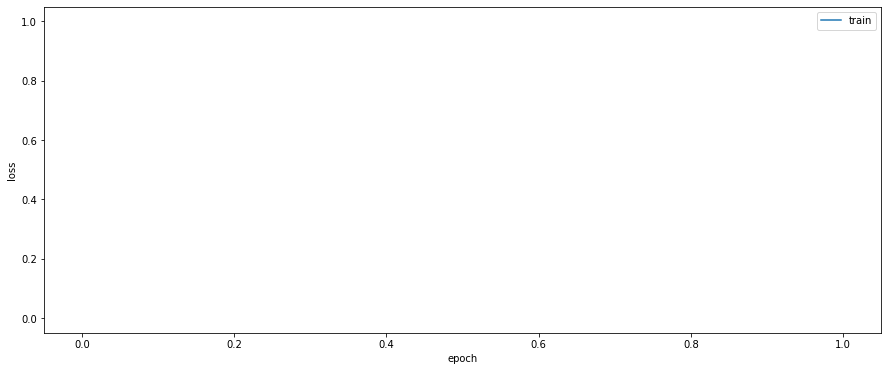

In [0]:
figsize(15,6)
plt.plot(history_loss)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper right')
plt.show()

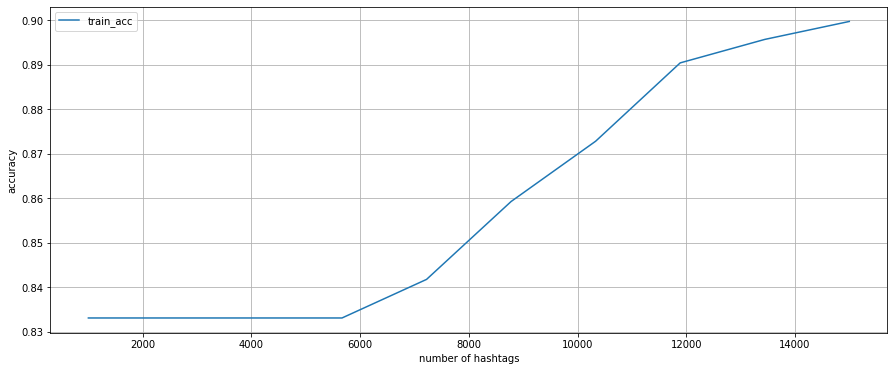

In [0]:
figsize(15,6)
scalar_space = np.linspace(1000, 15000, len(train_accs_al))

plt.plot(scalar_space, train_accs_al, label='train_acc')
plt.xlabel('number of hashtags')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

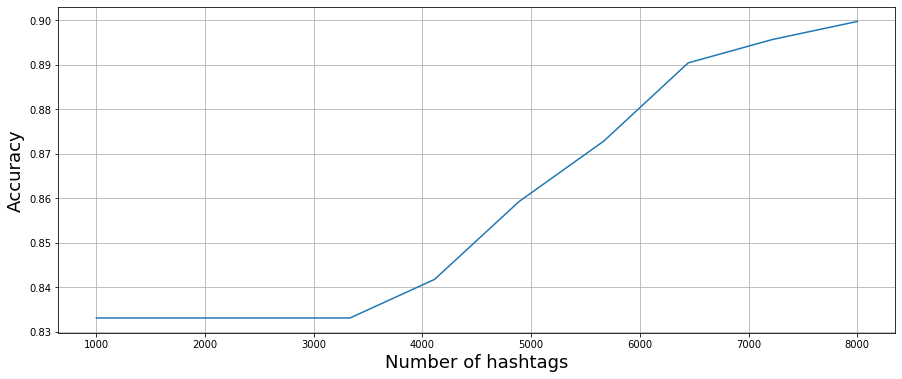

In [0]:
figsize(15,6)
scalar_space = np.linspace(1000, 8000, len(train_accs_al[:35]))
plt.plot(scalar_space, train_accs_al[:35])
plt.xlabel('Number of hashtags', fontsize=18)
plt.ylabel('Accuracy', fontsize=18)
plt.grid()

# AL experiment

top 7k of data after active learning    
7 epochs

In [0]:
data_al = pd.read_csv("./data_al.csv", index_col=None).iloc[:, 1:]
data_al.head()

FileNotFoundError: ignored

In [0]:
model_test = keras.models.Sequential()
model_test.add(L.InputLayer([None], dtype='int32'))
model_test.add(L.Embedding(len(all_chars), 50)) # dim 100
model_test.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))
stepwise_dense = L.Dense(2, activation='softmax')
stepwise_dense = L.TimeDistributed(stepwise_dense)
model_test.add(stepwise_dense)

In [0]:
model_test.compile('adam', 'categorical_crossentropy')

In [0]:
train_data = data_al.iloc[:7000]
test_data = data_al.iloc[7000:]

NameError: ignored

In [0]:
history = model_test.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                                   callbacks=[EvaluateAccuracy()], epochs=7,)

Epoch 1/7
32/31 [==============================] - 6s 173ms/step - loss: 0.4116

Measuring validation accuracy...
12000/14000 [========================>.....] - ETA: 1s

KeyboardInterrupt: ignored

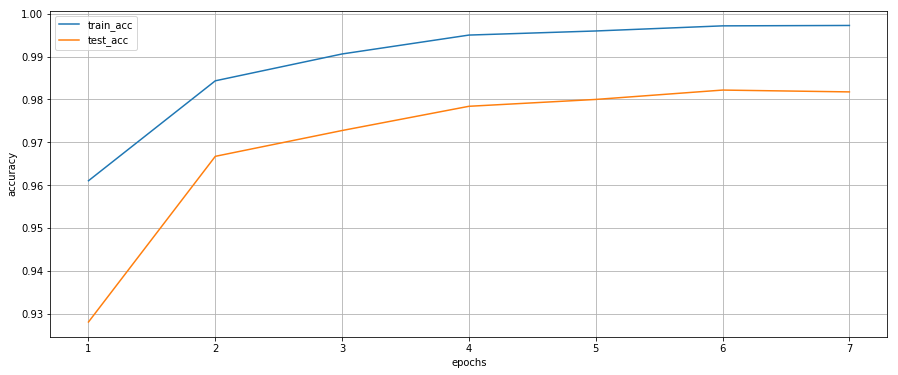

In [0]:
figsize(15,6)
# scalar_space = np.linspace(10000, 20000, 11)
#scalar_space = np.linspace(5000, 15000, 12)
scalar_space = np.linspace(1, 7, len(train_accs))

plt.plot(scalar_space, train_accs, label='train_acc')
plt.plot(scalar_space, test_accs, label='test_acc')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.grid()
plt.legend()

In [0]:
embeddings = model_test.layers[1].get_weights()[0]
len(embeddings)

73

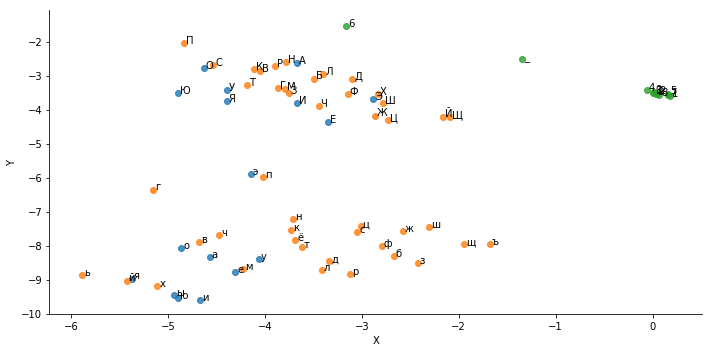

In [0]:
tsne_model = TSNE(n_components=2, random_state=0)
tsne_vectors = tsne_model.fit_transform(embeddings)
tx, ty = tsne_vectors[:, 0], tsne_vectors[:, 1]
build_plot(tx, ty, list(all_chars), sound_distribution)

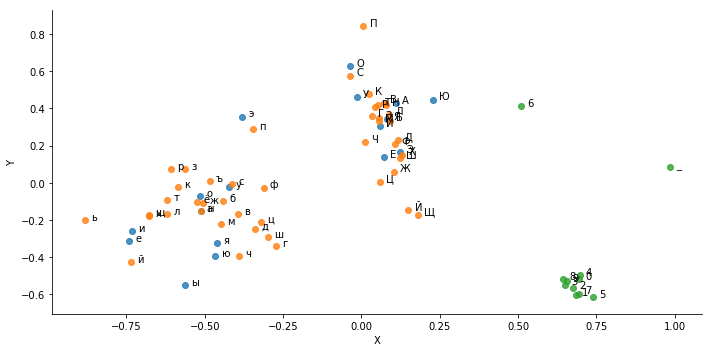

In [0]:
svd_model = TruncatedSVD(n_components=4, random_state=0)
svd_vectors = svd_model.fit_transform(embeddings)
sx, sy = svd_vectors[:, 0], svd_vectors[:, 1]
build_plot(sx, sy, list(all_chars), sound_distribution)

In [0]:
hashtags_x = train_data.hashtag.values
hashtags_y = train_data.hashtag_class.values

In [0]:
classes_dict_al = {i: 0 for i in np.unique(hashtags_y)}

In [0]:
for i, el in enumerate(hashtags_y):
    classes_dict_al[el] += 1

In [0]:
classes_dict_al

{0: 404,
 1: 571,
 2: 335,
 3: 1775,
 4: 298,
 5: 474,
 6: 1022,
 7: 1215,
 8: 131,
 9: 391,
 10: 384}

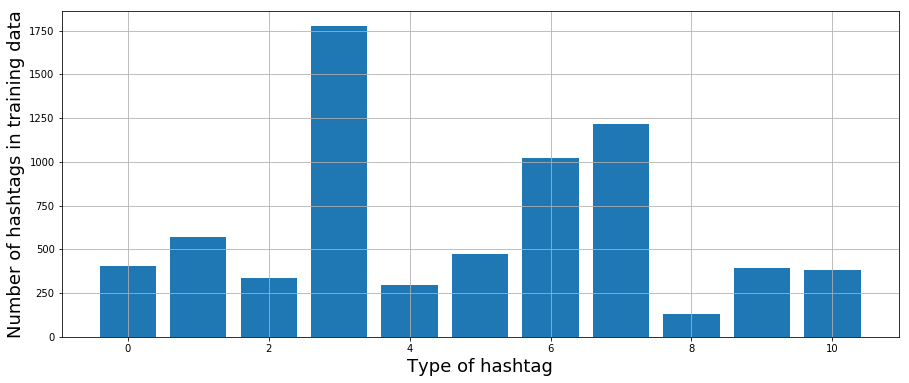

In [0]:
figsize(15,6)
x = classes_dict_al.keys()
y = classes_dict_al.values()
plt.xlabel("Type of hashtag", fontsize=18)
plt.ylabel("Number of hashtags in training data", fontsize=18)
plt.bar(x, y)
plt.grid()

# Leave-one-out

2000 экспериментов

потом усредняем accuracy

In [0]:
data = pd.read_csv("./dummy_data_all_types.csv", index_col=None).iloc[:, 1:]

history_loss = []

for i in range(len(real_test_data)):

    model = keras.models.Sequential()
    model.add(L.InputLayer([None], dtype='int32'))
    model.add(L.Embedding(len(all_chars), 50)) # dim 100
    model.add(L.Bidirectional(L.LSTM(64, return_sequences=True)))

    #add top layer that predicts tag probabilities

    stepwise_dense = L.Dense(2, activation='softmax')
    stepwise_dense = L.TimeDistributed(stepwise_dense)

    model.add(stepwise_dense)
    model.compile('adam', 'categorical_crossentropy')

    
    if i == 0:
        train_data = pd.concat([data, real_test_data.iloc[1:]])
        test_data = real_test_data.iloc[[0]]
    elif i == len(real_test_data):
        train_data = pd.concat([data, real_test_data.iloc[:-1]])
        test_data = real_test_data.iloc[[-1]]
    else:   
        train_data = pd.concat([data, real_test_data.iloc[:i], real_test_data.iloc[i+1:]])
        test_data = real_test_data.iloc[[i]]
    
    
    history = model.fit_generator(generate_batches(train_data), len(train_data)/BATCH_SIZE,
                    callbacks=[EvaluateAccuracy()], epochs=1,)
    
    #histoty_loss += history.history['loss']
    history_loss.append(history.history['loss'])
    print('ITERATION: ', i)

Epoch 1/1
374/373 [==============================] - 47s 127ms/step - loss: 0.1336

Measuring validation accuracy...
1943/1943 [==============================] - 1s 710us/step

Validation accuracy: 0.93333


Real test_data accuracy: 0.97096

ITERATION:  0
Epoch 1/1
374/373 [==============================] - 48s 128ms/step - loss: 0.1414

Measuring validation accuracy...
1943/1943 [==============================] - 1s 715us/step

Validation accuracy: 0.85714


Real test_data accuracy: 0.96861

ITERATION:  1
Epoch 1/1
374/373 [==============================] - 48s 128ms/step - loss: 0.1338

Measuring validation accuracy...
1943/1943 [==============================] - 1s 720us/step

Validation accuracy: 0.75000


Real test_data accuracy: 0.97198

ITERATION:  2
Epoch 1/1
374/373 [==============================] - 49s 131ms/step - loss: 0.1393

Measuring validation accuracy...
1943/1943 [==============================] - 1s 760us/step

Validation accuracy: 0.75000


Real test_data accuracy:

KeyboardInterrupt: 

In [0]:
len(history_loss)

23

In [0]:
#history_loss = [i[0] for i in history_loss]
np.mean(history_loss)

0.13937908790438247